In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import astropy.units as u
import math
import scipy.stats as stats
from tqdm import tqdm 
import time
import multiprocessing as mp
from scipy.stats import norm
from scipy.stats import poisson
from scipy.optimize import curve_fit
#import latexify
import random
import scipy.special as sp
from scipy import signal
from scipy.fft import fft, fftfreq, fftshift
from scipy.signal import butter, freqz, filtfilt
import datetime

## Projeto - Relatório de mercado por e-mail
 - E-mail automatico todos os dias com informações atualizadas sobre o fechamento ibovespa e dólar.
 - O conteúdo do e-mail deve também conter os plots
 
 
 Ref: Yahoo Finance

In [2]:
import yfinance as yf
import mplcyberpunk
#import win32.client as win32 
# -> para mandar e-mail automatico. precisa do windows

In [1]:
codigos = ["^BVSP","BRL=X"] #ibovespa e dolar
hoje = datetime.datetime.now()
data_inicial = hoje - datetime.timedelta(days = 365) #pegando dados de um ano atrás
dados_mercado = yf.download(codigos, data_inicial,hoje)

dados_mercado

NameError: name 'datetime' is not defined

In [4]:
type(dados_mercado)

pandas.core.frame.DataFrame

 - Limpeza de dados

In [5]:
dados = dados_mercado['Adj Close'] #selecionando os dados de fechamento

In [6]:
dados

,BRL=X,^BVSP
Date,,
2022-02-11,5.248700,113572.0
2022-02-14,5.249956,113807.0
2022-02-15,5.214000,114660.0
2022-02-16,5.157900,115181.0
2022-02-17,5.135800,113528.0
...,...,...
2023-02-06,5.149800,108456.0
2023-02-07,5.145700,107920.0
2023-02-08,5.209300,109882.0


In [7]:
dados.columns = ['Dolar', 'Ibovespa']

In [8]:
dados

,Dolar,Ibovespa
Date,,
2022-02-11,5.248700,113572.0
2022-02-14,5.249956,113807.0
2022-02-15,5.214000,114660.0
2022-02-16,5.157900,115181.0
2022-02-17,5.135800,113528.0
...,...,...
2023-02-06,5.149800,108456.0
2023-02-07,5.145700,107920.0
2023-02-08,5.209300,109882.0


As vezes o mercado de cambio abre em dias que o ibovespa não está aberto. 
- Retirando dados NaN

In [9]:
dados = dados.dropna()
dados

,Dolar,Ibovespa
Date,,
2022-02-11,5.248700,113572.0
2022-02-14,5.249956,113807.0
2022-02-15,5.214000,114660.0
2022-02-16,5.157900,115181.0
2022-02-17,5.135800,113528.0
...,...,...
2023-02-06,5.149800,108456.0
2023-02-07,5.145700,107920.0
2023-02-08,5.209300,109882.0


In [10]:
## criar tabela com outros timeframes (cotação diária -> rendimento mensal, trisemestral...)
dados_anuais = dados.resample("Y").last()
dados_anuais

#estudar pd.resample().[last(), sum(), ...]

,Dolar,Ibovespa
Date,,
2022-12-31,5.2668,110031.0
2023-12-31,5.2895,108150.0


In [11]:
dados.loc['2022-12-29'] #Ultimos valores do ano de 2022

Dolar            5.2668
Ibovespa    110031.0000
Name: 2022-12-29 00:00:00, dtype: float64

In [12]:
dados.loc['2023-02-09'] #ultimos valores do ano de 2023 até agora
#bate com a função .last()

Dolar            5.1995
Ibovespa    107783.0000
Name: 2023-02-09 00:00:00, dtype: float64

In [13]:
dados_mensais = dados.resample("M").last()
dados_mensais

,Dolar,Ibovespa
Date,,
2022-02-28,5.1222,113142.0
2022-03-31,4.7697,119999.0
2022-04-30,4.9378,107876.0
2022-05-31,4.7524,111351.0
2022-06-30,5.1809,98542.0
2022-07-31,5.1827,103165.0
2022-08-31,5.1219,109523.0
2022-09-30,5.3962,110037.0
2022-10-31,5.2885,116037.0


In [14]:
dados_trimestrais = dados.resample("3M").last()
dados_trimestrais

,Dolar,Ibovespa
Date,,
2022-02-28,5.1222,113142.0
2022-05-31,4.7524,111351.0
2022-08-31,5.1219,109523.0
2022-11-30,5.2682,112486.0
2023-02-28,5.2895,108150.0


In [15]:
media_anual = dados.resample("Y").mean()
media_anual

,Dolar,Ibovespa
Date,,
2022-12-31,5.125084,109792.932127
2023-12-31,5.186919,110311.266667


In [16]:
#calcular fechamento do dia, retorno no ano e retorno no mês dos ativos

dados_anuais

,Dolar,Ibovespa
Date,,
2022-12-31,5.2668,110031.0
2023-12-31,5.2895,108150.0


In [17]:
#Jeito raiz de calcular rentabilidade (dolar)
(dados_anuais.loc['2023-12-31'][0] / dados_anuais.loc['2022-12-31'][0]) - 1

0.004310076340301006

In [18]:
retorno_anual = dados_anuais.pct_change() #funcao que automatiza isso
retorno_anual

,Dolar,Ibovespa
Date,,
2022-12-31,NaN,NaN
2023-12-31,0.00431,-0.017095


NaN no primeiro ano já que não há variação (é preciso dados do ano anterior).

In [19]:
retorno_anual = retorno_anual.dropna()

In [20]:
### da pra simplificar anteriormente:
dados_anuais.pct_change().dropna()

,Dolar,Ibovespa
Date,,
2023-12-31,0.00431,-0.017095


In [21]:
retorno_mensal = dados_mensais.pct_change().dropna()
retorno_mensal

,Dolar,Ibovespa
Date,,
2022-03-31,-0.068818,0.060605
2022-04-30,0.035243,-0.101026
2022-05-31,-0.037547,0.032213
2022-06-30,0.090165,-0.115033
2022-07-31,0.000347,0.046914
2022-08-31,-0.011731,0.061629
2022-09-30,0.053554,0.004693
2022-10-31,-0.019959,0.054527
2022-11-30,-0.003839,-0.030602


In [22]:
retorno_diario = dados.pct_change().dropna()
retorno_diario

,Dolar,Ibovespa
Date,,
2022-02-14,0.000239,0.002069
2022-02-15,-0.006849,0.007495
2022-02-16,-0.010760,0.004544
2022-02-17,-0.004285,-0.014351
2022-02-18,0.006776,-0.006694
...,...,...
2023-02-06,0.019924,-0.000313
2023-02-07,-0.000796,-0.004942
2023-02-08,0.012360,0.018180


In [23]:
## localizando o fechamento especifico
retorno_fev_14_2022 = retorno_diario.loc['2022-02-14','Dolar']
print(str(retorno_fev_14_2022*100)+'%')

0.023929526182664418%


In [24]:
#pegando retorno diario do ultimo dia util do ibovespa
retorno_diario_dolar = round(retorno_diario.iloc[-1,0]*100,2)
retorno_diario_ibov = round(retorno_diario.iloc[-1,1]*100,2)
retorno_diario_ibov

0.34

In [25]:
retorno_mensal_dolar = round(retorno_mensal.iloc[-1,0]*100,2)
retorno_mensal_ibov = round(retorno_mensal.iloc[-1,1],2)

retorno_anual_dolar = round(retorno_anual.iloc[-1,0],2)
retorno_anual_ibov = round(retorno_anual.iloc[-1,1],2)

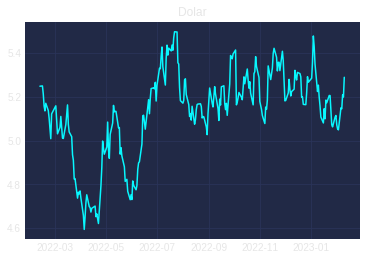

In [26]:
### graficos de performance
#da pra usar dados.plot(y='nome da coluna', use_index = True, legend = False)
plt.style.use('cyberpunk')
plt.title('Dolar')
plt.plot(dados['Dolar'])

#salvar a imagem
plt.savefig('dolar.png', dpi = 300)

plt.show()

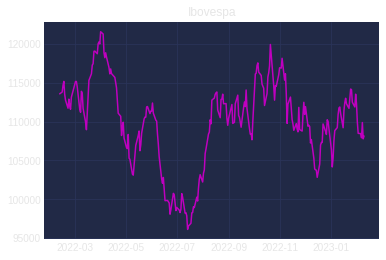

In [27]:
plt.title('Ibovespa')
plt.plot(dados['Ibovespa'],color = 'm')
plt.savefig('ibovespa.png', dpi = 300)
plt.show()

(1200, 1800, 4)


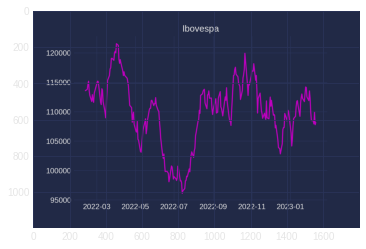

In [28]:
#verificando se as imagens foram carregadas
attachment1 = open("/home/laidler/Documentos/Thiago/Financas/ibovespa.png", "rb")
attachment2 = open("/home/laidler/Documentos/Thiago/Financas/dolar.png", "rb")

from skimage import io

img = io.imread(attachment1)  #carregamento imagem
plt.imshow(img) #exibição da imagem
#os pixels da imagem estao salvas na array
#print(img)
print(img.shape) #quantos pixels ele tem e seus canais rgb (vermelho, verde e azul)

(1200, 1800, 4)


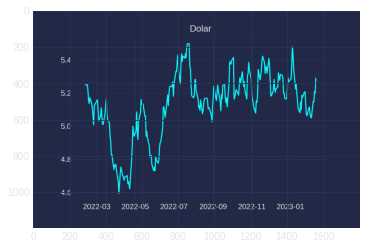

In [29]:
img = io.imread(attachment2)  #carregamento imagem
plt.imshow(img) #exibição da imagem
#os pixels da imagem estao salvas na array
#print(img)
print(img.shape) #quantos pixels ele tem e seus canais rgb (vermelho, verde e azul)

In [30]:
### versão completa
# enviar gmail com anexo

# Python code to illustrate Sending mail with attachments
# from your Gmail account

# libraries to be imported
import smtplib
from email.mime.multipart import MIMEMultipart
from email.mime.text import MIMEText
from email.mime.base import MIMEBase
from email import encoders

fromaddr = "thiagolaidler@gmail.com"
remetentes = ['thiago18@ov.ufrj.br']
toaddr = " , ".join(remetentes)

# instance of MIMEMultipart
msg = MIMEMultipart()

# storing the senders email address
msg['From'] = fromaddr

# storing the receivers email address
msg['To'] = toaddr

# storing the subject
msg['Subject'] = "Relatorio Automático"

# string to store the body of the mail
body = f''' 
    Prezado,
    
    Segue meu primeiro e-mail automatico.
    O rendimento mensal do ibovespa foi de {retorno_mensal_ibov}%
    O rendimento mensal do dólar foi de {retorno_mensal_dolar}%
    Quanto aos rendimentos anuais, temos que o ibovespa retornou {retorno_anual_ibov}% e o dolar retornou {retorno_anual_dolar}%.
    
    Segue em anexo os gráficos que mostram a evolução destes rendimentos.
    
    Abraços!
    
    
    Thiago Laidler.
    '''

# attach the body with the msg instance
msg.attach(MIMEText(body, 'plain'))

# open the file to be sent
filename = "ibovespa.png"
attachment = open("/home/laidler/Documentos/Thiago/Financas/ibovespa.png", "rb")

filename2 = "dolar.png"
attachment2 = open("/home/laidler/Documentos/Thiago/Financas/dolar.png", "rb")

# instance of MIMEBase and named as p
p = MIMEBase('application', 'octet-stream')

# To change the payload into encoded form
p.set_payload((attachment).read())

# encode into base64
encoders.encode_base64(p)

p.add_header('Content-Disposition', "attachment; filename= %s" % filename)

# attach the instance 'p' to instance 'msg'
msg.attach(p)


# instance of MIMEBase and named as p
p2 = MIMEBase('application', 'octet-stream')

# To change the payload into encoded form
p2.set_payload((attachment2).read())

# encode into base64
encoders.encode_base64(p2)

p2.add_header('Content-Disposition', "attachment2; filename= %s" % filename2)

# attach the instance 'p' to instance 'msg'
msg.attach(p2)

####Para mais anexos, basta repetir para p3, p4... e assim em diante

# creates SMTP session
s = smtplib.SMTP('smtp.gmail.com', 587)

# start TLS for security
s.starttls()

# Authentication
s.login(fromaddr, "krihsbsblxjmpzds")

# Converts the Multipart msg into a string
text = msg.as_string()

# sending the mail
s.sendmail(fromaddr, remetentes, text)

# terminating the session
s.quit()

(221,
 b'2.0.0 closing connection r1-20020a05687002c100b0014c8b5d54b2sm2598855oaf.20 - gsmtp')